In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
import os
import math
%matplotlib inline

In [2]:
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams.update({'font.size': 20})

In [3]:
df_ics = pd.read_csv("coupledWReg/crosstalk_singles/emtmrH_lamdaHS_7_100_ics.txt")
df_res = pd.read_csv("coupledWReg/crosstalk_singles/emtmrH_lamdaHS_7_100_res.txt")

In [4]:
def plotHeatmap(x,y,nbin,xlabel='',ylabel='',title='',hold=False):

    [HH,xh,yh] = np.histogram2d(x,y,bins=(nbin,nbin))
    HH = HH.T/(1.)
    xmin,xmax=xh[0],xh[-1]
    ymin,ymax=yh[0],yh[-1]
    plt.imshow(HH,interpolation='nearest',origin='low',extent=[xmin,xmax,ymin,ymax],aspect='auto',cmap='gist_ncar')#,cmap='jet',vmin=0.,vmax=100,aspect='auto')
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)    
    plt.title(title)   
    if not hold:
        plt.show()
    plt.close()
    return [HH,xh,yh]

In [5]:
def stateThresholds():
    ''''''
    return {'Zeb mRNA':[ 62+(301-62)/2.,301+(990-301)/2.]
            ,'$\mu_{200}$':[1265+(12389-1265)/2.,12389+(19098-12389)/2.],
            'Hif-1':[26+(292-26)/2.,292+(490-292)/2.],
            'AMPK':[69+(327-69)/2.,327+(436-327)/2.]}

In [6]:
def getStates_fromMap(df_res,hold=False):

    x2 = df_res['A']
    y2 = df_res['mz']
    x1 = df_res['u']
    y1 = df_res['h']
    hm1= plotHeatmap(x1,y1,10,'$\mu_{200}$','Hif-1','Steady States',hold)
    hm2 =plotHeatmap(x2,y2,10,'AMPK','Zeb mRNA','Steady States',hold)
    res2,res1={'n':[],'A':[],'mz':[]},{'n':[],'u':[],'h':[]}
    nr,nc = hm1[0].shape
    for i in range(nr):
        for j in range(nc):
            if hm1[0][i][j]>0:
                res1['n']+=[hm1[0][i][j]]
                res1['u']+=[hm1[1][j]]
                res1['h']+=[hm1[2][i]]

    nr,nc = hm2[0].shape      
    for i in range(nr):
        for j in range(nc):
            if hm2[0][i][j]>0:
                res2['n']+=[hm2[0][i][j]]
                res2['A']+=[hm2[1][j]]
                res2['mz']+=[hm2[2][i]]

    thresh = stateThresholds()

    results={'name':[],'loc':[],'amount':[]}
    resultsE={'name':[],'loc':[],'amount':[]}
    resultsM={'name':[],'loc':[],'amount':[]}
    met={}
    emt={}
    for row in range(len(res2['n'])):
        if res2['A'][row]<=thresh['AMPK'][0] :
            #low AMPK warburg
            ms='W'
        elif (res2['A'][row]>thresh['AMPK'][0]) and (res2['A'][row]<=thresh['AMPK'][1]) :
            # hybrid - intermediate ampk
            ms = 'WO'
        elif res2['A'][row]>thresh['AMPK'][1] :
            # high ampk oxphos
            ms='O'
        else:
            ms = 'NA'
        if res2['mz'][row]<=thresh['Zeb mRNA'][0] :
            #low Zeb - epithelial
            es='E'
        elif (res2['mz'][row]>thresh['Zeb mRNA'][0]) and (res2['mz'][row]<=thresh['Zeb mRNA'][1]) :
            # hybrid - intermediate zeb mrna
            es = 'EM'
        elif res2['mz'][row]>thresh['Zeb mRNA'][1] :
            # high zeb mesenchymal
            es='M'
        else:
            es = 'NA'    

        if res2['n'][row] not in met.keys():
            met[res2['n'][row]]=[ms]
            emt[res2['n'][row]]=[es]
        else:
            met[res2['n'][row]]+=[ms]
            emt[res2['n'][row]]+=[es]

    for row in range(len(res1['n'])):
        if res1['h'][row]<=thresh['Hif-1'][0] :
            #low hif1 oxphos
            ms='O'
        elif (res1['h'][row]>thresh['Hif-1'][0]) and (res1['h'][row]<=thresh['Hif-1'][1]) :
            # hybrid - intermediate 
            ms = 'WO'
        elif res1['h'][row]>thresh['Hif-1'][1] :
            # high hif1 warburg
            ms='W'
        else:
            ms = 'NA'
        if res1['u'][row]<=thresh['$\mu_{200}$'][0] :
            #low u200 - mesenchymal
            es='M'
        elif (res1['u'][row]>thresh['$\mu_{200}$'][0]) and (res1['u'][row]<=thresh['$\mu_{200}$'][1]) :
            # hybrid - intermediate 
            es = 'EM'
        elif res1['u'][row]>thresh['$\mu_{200}$'][1] :
            # high u200 epithelial
            es='E'
        else:
            es = 'NA'    


        if res1['n'][row] not in met.keys():
            met[res1['n'][row]]=[ms]
            emt[res1['n'][row]]=[es]
        else:
            for i in range(len(met[res1['n'][row]])):
                containedM=False
                if met[res1['n'][row]][i]==ms:
                    containedM=True
                if not containedM:
                    print "error in ",res1['n'][row]
                containedE=False
                if emt[res1['n'][row]][i]==es:
                    containedE=True
                if not containedE:
                    print "error in ",res1['n'][row]

                    
    count=0
    for i in met:
        for j in range(len(met[i])):
            tmp = emt[i][j]+"/"+met[i][j]
            results['name']+=[tmp]
            results['loc']+=[count]
            results['amount']+=[i]
            count+=1
        
    resultsE['name'] = ['E/O','E/WO','E/W','EM/O','EM/WO','EM/W','M/O','M/WO','M/W',]
    resultsM['name'] = ['E/O','EM/O','M/O','E/WO','EM/WO','M/WO','E/W','EM/W','M/W']
        
    tmpL = len(results['name'])
    for i in range(len(resultsE['name'])):
        added=False
        for j in range(len(results['name'])):
            if resultsE['name'][i]==results['name'][j]:
                resultsE['loc']+=[results['loc'][j]]
                resultsE['amount']+=[results['amount'][j]]
                added=True
        if not added:
            resultsE['loc']+= [tmpL]
            resultsE['amount']+=[0]
            tmpL+=1
    tmpL = len(results['name'])
    for i in range(len(resultsM['name'])):
        added=False
        for j in range(len(results['name'])):
            if resultsM['name'][i]==results['name'][j]:
                resultsM['loc']+=[results['loc'][j]]
                resultsM['amount']+=[results['amount'][j]]
                added=True
        if not added:
            resultsM['loc']+= [tmpL]
            resultsM['amount']+=[0]
            tmpL+=1
            #print resultsM['name'][i],resultsM['loc'][i],resultsM['amount'][i]
            
            

    return results,resultsE,resultsM,np.max(results['amount'])

In [7]:
def plotRes(filename):
    df_res = pd.read_csv(filename).dropna()  
    mapRes,mapResE,mapResM,maxC =getStates_fromMap(df_res)
    
    my_cmap = mpl.cm.get_cmap('rainbow')#gist_ncar')
    my_norm = Normalize(vmin=0, vmax=maxC)
    #ax.bar(range(8), rand(8), color=my_cmap(my_norm(data)))
    
    xvals = np.arange(0,len(mapRes['amount']))
    plt.bar(xvals,mapRes['amount'],color=my_cmap(my_norm(mapRes['amount'])))
    plt.xticks(xvals,mapRes['name'],rotation=80)
    plt.yscale("log")
    plt.xlabel("Steady state")
    plt.ylabel("Number of Initial Conditions")
    plt.show()
    plt.close()

    fig = plt.figure()
    xvals = np.arange(0,len(mapResE['amount']))
    plt.bar(xvals,mapResE['amount'],color=my_cmap(my_norm(mapResE['amount'])))
    plt.xticks(xvals,mapResE['name'],rotation=80)
    plt.yscale("log")
    plt.xlabel("Steady state")
    plt.ylabel("Number of Initial Conditions")
    title = filename.replace("res","emt")
    title = title.replace("txt","png")
    print title
    fig.savefig(title,bbox_inches='tight')
    plt.show()
    plt.close()

    fig = plt.figure()
    xvals = np.arange(0,len(mapResM['amount']))
    plt.bar(xvals,mapResM['amount'],color=my_cmap(my_norm(mapResM['amount'])))
    plt.xticks(xvals,mapResM['name'],rotation=80)
    plt.yscale("log")
    plt.xlabel("Steady state")
    plt.ylabel("Number of Initial Conditions")
    title = filename.replace("txt","png")
    title = title.replace("res","mr")
    print title
    fig.savefig(title,bbox_inches='tight')
    
    plt.show()


In [8]:
def getStates_fromMap2(df_res,show=True):

    x2 = df_res['A']
    y2 = df_res['mz']
    x1 = df_res['u']
    y1 = df_res['h']
    
    nbin=10
    [HH,xh,yh] = np.histogram2d(x1,y1,bins=(nbin,nbin))
    HH = HH.T/(1.)
    hm1=[HH,xh,yh]
    [HH,xh,yh] = np.histogram2d(x2,y2,bins=(nbin,nbin))
    HH = HH.T/(1.)
    hm2=[HH,xh,yh]
    
    res2,res1={'n':[],'A':[],'mz':[]},{'n':[],'u':[],'h':[]}
    nr,nc = hm1[0].shape
    for i in range(nr):
        for j in range(nc):
            if hm1[0][i][j]>0:
                res1['n']+=[hm1[0][i][j]]
                res1['u']+=[hm1[1][j]]
                res1['h']+=[hm1[2][i]]

    nr,nc = hm2[0].shape      
    for i in range(nr):
        for j in range(nc):
            if hm2[0][i][j]>0:
                res2['n']+=[hm2[0][i][j]]
                res2['A']+=[hm2[1][j]]
                res2['mz']+=[hm2[2][i]]

    thresh = stateThresholds()

    set1={'E':0,'EM':0,'M':0,'O':0,'WO':0,'W':0}
    for row in range(len(res1['n'])):
        if res1['h'][row]<=thresh['Hif-1'][0] :
            #low hif1 oxphos
            set1['O']+=res1['n'][row]
        elif (res1['h'][row]>thresh['Hif-1'][0]) and (res1['h'][row]<=thresh['Hif-1'][1]) :
            # hybrid - intermediate 
            set1['WO']+=res1['n'][row]
        elif res1['h'][row]>thresh['Hif-1'][1] :
            # high hif1 warburg
            set1['W']+=res1['n'][row]
        if res1['u'][row]<=thresh['$\mu_{200}$'][0] :
            #low u200 - mesenchymal
            set1['M']+=res1['n'][row]
        elif (res1['u'][row]>thresh['$\mu_{200}$'][0]) and (res1['u'][row]<=thresh['$\mu_{200}$'][1]) :
            # hybrid - intermediate 
            set1['EM']+=res1['n'][row]
        elif res1['u'][row]>thresh['$\mu_{200}$'][1] :
            # high u200 epithelial
            set1['E']+=res1['n'][row]

    set2={'E':0,'EM':0,'M':0,'O':0,'WO':0,'W':0}
    for row in range(len(res2['n'])):
        if res2['A'][row]<=thresh['AMPK'][0] :
            #low AMPK warburg
            set2['W']+=res2['n'][row]
        elif (res2['A'][row]>thresh['AMPK'][0]) and (res2['A'][row]<=thresh['AMPK'][1]) :
            # hybrid - intermediate ampk
            set2['WO']+=res2['n'][row]
        elif res2['A'][row]>thresh['AMPK'][1] :
            # high ampk oxphos
            set2['O']+=res2['n'][row]
        if res2['mz'][row]<=thresh['Zeb mRNA'][0] :
            #low Zeb - epithelial
            set2['E']+=res2['n'][row]
        elif (res2['mz'][row]>thresh['Zeb mRNA'][0]) and (res2['mz'][row]<=thresh['Zeb mRNA'][1]) :
            # hybrid - intermediate zeb mrna
            set2['EM']+=res2['n'][row]
        elif res2['mz'][row]>thresh['Zeb mRNA'][1] :
            # high zeb mesenchymal
            set2['M']+=res2['n'][row]

    for key in set1:
        if set1[key] != set2[key]:
            print "error, mismatch in ", key
    return set1

In [9]:
direct = "coupledWReg_Ccode/crosstalk_singles/"
regs={}
for filen in os.listdir(direct):
    if "res.txt" in filen:
        name= filen.split(".")[0].split("_")[2]
        lamda=''
        while name[-1].isdigit():
            lamda+=name[-1]
            name = name[:-1]
        
        if name not in regs.keys():
            regs[name]=[]
        regs[name]+=[lamda]

        
regsI,regsA={},{}
for k in regs:
    if 0 in np.array(regs[k]).astype(float):
        regsI[k]=regs[k]
    else:
        regsA[k] = regs[k]
    

In [10]:
def plotPerc(name,fcL):
    
    results={'E/O':[[],[]],'E/W':[[],[]],'E/WO':[[],[]],'EM/O':[[],[]],'EM/W':[[],[]],'EM/WO':[[],[]],'M/O':[[],[]],'M/W':[[],[]],'M/WO':[[],[]]}
    for i in range(len(fcL)):
        nics=1000.
        df = pd.read_csv("coupledWReg_Ccode/crosstalk_singles/EMT_MR_"+str(name)+str(regs[name][i])+"_"+str(int(nics))+"_res.txt").dropna()

        mapRes,mapResE,mapResM,maxC =getStates_fromMap(df,hold=True)
        for k in range(len(mapResE['name'])):
            tmp = mapResE['name'][k]
            results[tmp][0]+=[fcL[i]] 
            results[tmp][1]+=[mapResE['amount'][k]/nics*100.]
        
    print results['E/O'][0]
    for key in results:
        ind = np.argsort(results[key][0])
        results[key][0] = np.array(results[key][0])[ind]
        results[key][1] = np.array(results[key][1])[ind]
    
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(30,30))
    ax1.plot(results['E/O'][0],results['E/O'][1],'*-',markersize=20,label='name')#,color=my_cmap(my_norm(mapResE['amount']/nics)))
    ax1.set_xlabel("Foldchange")#"Steady state")
    ax1.set_ylabel("Percentage IC ")
    ax2.plot(results['E/WO'][0],results['E/WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
    ax2.set_xlabel("Foldchange")#"Steady state")
    #ax2.set_ylabel("Percentage IC ")
    ax3.plot(results['E/W'][0],results['E/W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
    ax3.set_xlabel("Foldchange")#"Steady state")
    #ax3.set_ylabel("Percentage IC ")
    ax4.plot(results['EM/O'][0],results['EM/O'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
    ax4.set_xlabel("Foldchange")#"Steady state")
    #ax4.set_ylabel("Percentage IC ")
    ax5.plot(results['EM/WO'][0],results['EM/WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
    ax5.set_xlabel("Foldchange")#"Steady state")
    #ax5.set_ylabel("Percentage IC ")
    ax6.plot(results['EM/W'][0],results['EM/W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
    ax6.set_xlabel("Foldchange")#"Steady state")
    ax6.set_ylabel("Percentage IC ")
    ax7.plot(results['M/O'][0],results['M/O'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
    ax7.set_xlabel("Foldchange")#"Steady state")
    #ax7.set_ylabel("Percentage IC ")
    ax8.plot(results['M/WO'][0],results['M/WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
    ax8.set_xlabel("Foldchange")#"Steady state")
    #ax8.set_ylabel("Percentage IC ")
    ax9.plot(results['M/W'][0],results['M/W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
    ax9.set_xlabel("Foldchange")#"Steady state")
    ax9.set_ylabel("Percentage IC ")
    plt.show()
    #plt.close()


error in  6.0
error in  6.0
['0', '5', '2', '6', '1', '4', '3', '7', '8', '9']


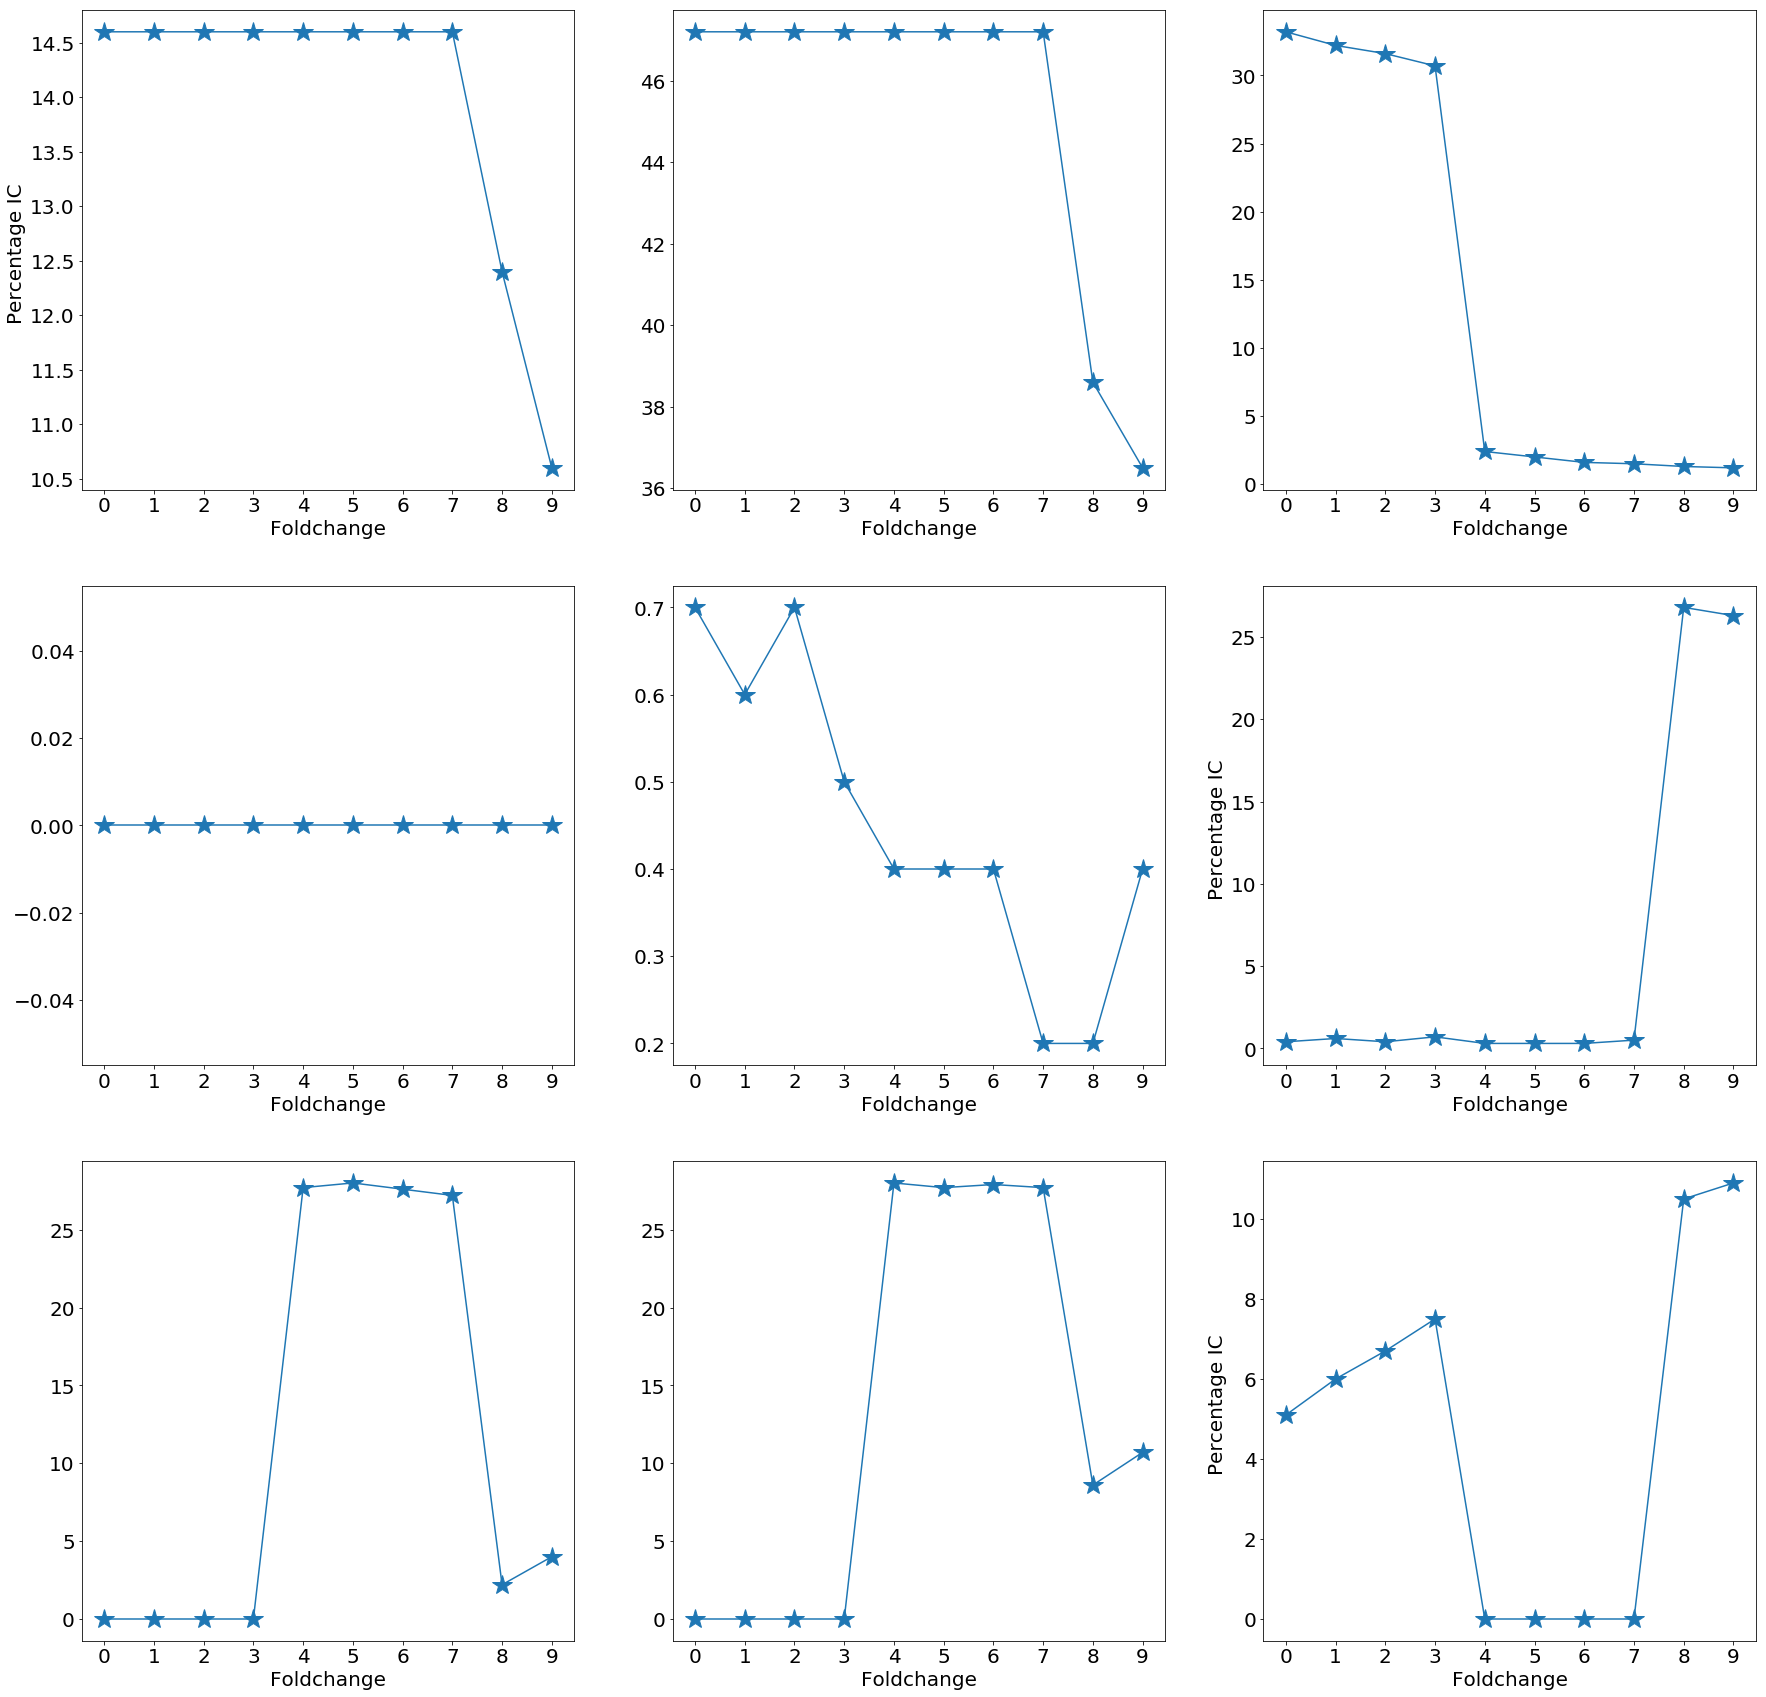

In [11]:

plotPerc('lamdaAZ',regs['lamdaAZ'])


In [40]:
def plotPercAll(regs):
    
    results={}
    for name in regs:
        fcL = np.array(regs[name]).astype(float)
        if 0 in fcL:
            fcL = fcL*0.1
        print fcL

        print name
    
        tmpL={'E/O':[[],[]],'E/W':[[],[]],'E/WO':[[],[]],'EM/O':[[],[]],'EM/W':[[],[]],'EM/WO':[[],[]],'M/O':[[],[]],'M/W':[[],[]],'M/WO':[[],[]]}
        for i in range(len(fcL)):
            nics=1000.
            df = pd.read_csv("coupledWReg_Ccode/crosstalk_singles/EMT_MR_"+str(name)+str(regs[name][i])+"_"+str(int(nics))+"_res.txt").dropna()

            mapRes,mapResE,mapResM,maxC =getStates_fromMap(df,hold=True)
            for k in range(len(mapResE['name'])):
                tmp = mapResE['name'][k]
                tmpL[tmp][0]+=[fcL[i]] 
                tmpL[tmp][1]+=[mapResE['amount'][k]/nics*100.]

        print tmpL['E/O'][0]
        for key in tmpL:
            ind = np.argsort(tmpL[key][0])
            tmpL[key][0] = np.array(tmpL[key][0])[ind]
            tmpL[key][1] = np.array(tmpL[key][1])[ind]
            
        results[name]=tmpL
            
    print results.keys()
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(30,30))
    for name in results:
        print name
        for jj in range(len(results[name]['E/O'][0])):
            print results[name]['E/O'][1][jj]+results[name]['E/WO'][1][jj]+results[name]['E/W'][1][jj]+results[name]['EM/O'][1][jj]+results[name]['EM/WO'][1][jj]+results[name]['EM/W'][1][jj]+results[name]['M/O'][1][jj]+results[name]['M/WO'][1][jj]+results[name]['M/W'][1][jj],'\n'
        ax1.plot(results[name]['E/O'][0],results[name]['E/O'][1],'*-',markersize=20,label=name)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax2.plot(results[name]['E/WO'][0],results[name]['E/WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax3.plot(results[name]['E/W'][0],results[name]['E/W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax4.plot(results[name]['EM/O'][0],results[name]['EM/O'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax5.plot(results[name]['EM/WO'][0],results[name]['EM/WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax6.plot(results[name]['EM/W'][0],results[name]['EM/W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax7.plot(results[name]['M/O'][0],results[name]['M/O'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax8.plot(results[name]['M/WO'][0],results[name]['M/WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax9.plot(results[name]['M/W'][0],results[name]['M/W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax1.set_xlabel("Foldchange")#"Steady state")
        ax2.set_xlabel("Foldchange")#"Steady state")
        ax3.set_xlabel("Foldchange")#"Steady state")
        ax4.set_xlabel("Foldchange")#"Steady state")
        ax5.set_xlabel("Foldchange")#"Steady state")
        ax6.set_xlabel("Foldchange")#"Steady state")
        ax7.set_xlabel("Foldchange")#"Steady state")
        ax8.set_xlabel("Foldchange")#"Steady state")
        ax9.set_xlabel("Foldchange")#"Steady state")
        ax1.set_ylabel("Percentage IC ")
        ax2.set_ylabel("Percentage IC ")
        ax3.set_ylabel("Percentage IC ")
        ax4.set_ylabel("Percentage IC ")
        ax5.set_ylabel("Percentage IC ")
        ax6.set_ylabel("Percentage IC ")
        ax7.set_ylabel("Percentage IC ")
        ax8.set_ylabel("Percentage IC ")
        ax9.set_ylabel("Percentage IC ")
        ax1.set_title("E/O")
        ax2.set_title("E/WO")
        ax3.set_title("E/W")
        ax4.set_title("EM/O")
        ax5.set_title("EM/WO")
        ax6.set_title("EM/W")
        ax7.set_title("M/O")
        ax8.set_title("M/WO")
        ax9.set_title("M/W")
        ax1.legend()
    plt.show()
    #plt.close()


[2. 4. 7. 9. 1. 3. 8. 5. 6.]
lamdaAu
error in  1.0
error in  1.0
error in  1.0
error in  1.0
[2.0, 4.0, 7.0, 9.0, 1.0, 3.0, 8.0, 5.0, 6.0]
[9. 8. 3. 4. 7. 1. 6. 2. 5.]
lamdaHS
[9.0, 8.0, 3.0, 4.0, 7.0, 1.0, 6.0, 2.0, 5.0]
[4. 1. 3. 7. 8. 6. 9. 2. 5.]
lamdaHu
error in  6.0
error in  6.0
error in  1.0
error in  1.0
error in  1.0
error in  1.0
error in  1.0
error in  1.0
error in  1.0
error in  1.0
error in  1.0
error in  1.0
error in  4.0
[4.0, 1.0, 3.0, 7.0, 8.0, 6.0, 9.0, 2.0, 5.0]
[3. 5. 4. 7. 2. 1. 6. 8. 9.]
lamdau3Rn
error in  7.0
error in  7.0
[3.0, 5.0, 4.0, 7.0, 2.0, 1.0, 6.0, 8.0, 9.0]
[4. 7. 5. 1. 9. 3. 8. 2. 6.]
lamdau3Rm
error in  42.0
error in  68.0
error in  3.0
error in  44.0
error in  72.0
error in  4.0
error in  46.0
error in  84.0
error in  4.0
error in  4.0
error in  4.0
error in  4.0
[4.0, 7.0, 5.0, 1.0, 9.0, 3.0, 8.0, 2.0, 6.0]
['lamdau3Rn', 'lamdaHS', 'lamdaHu', 'lamdaAu', 'lamdau3Rm']
lamdau3Rn
100.00000000000001 

100.0 

100.1 

101.6 

100.49999999999999 

60.0 

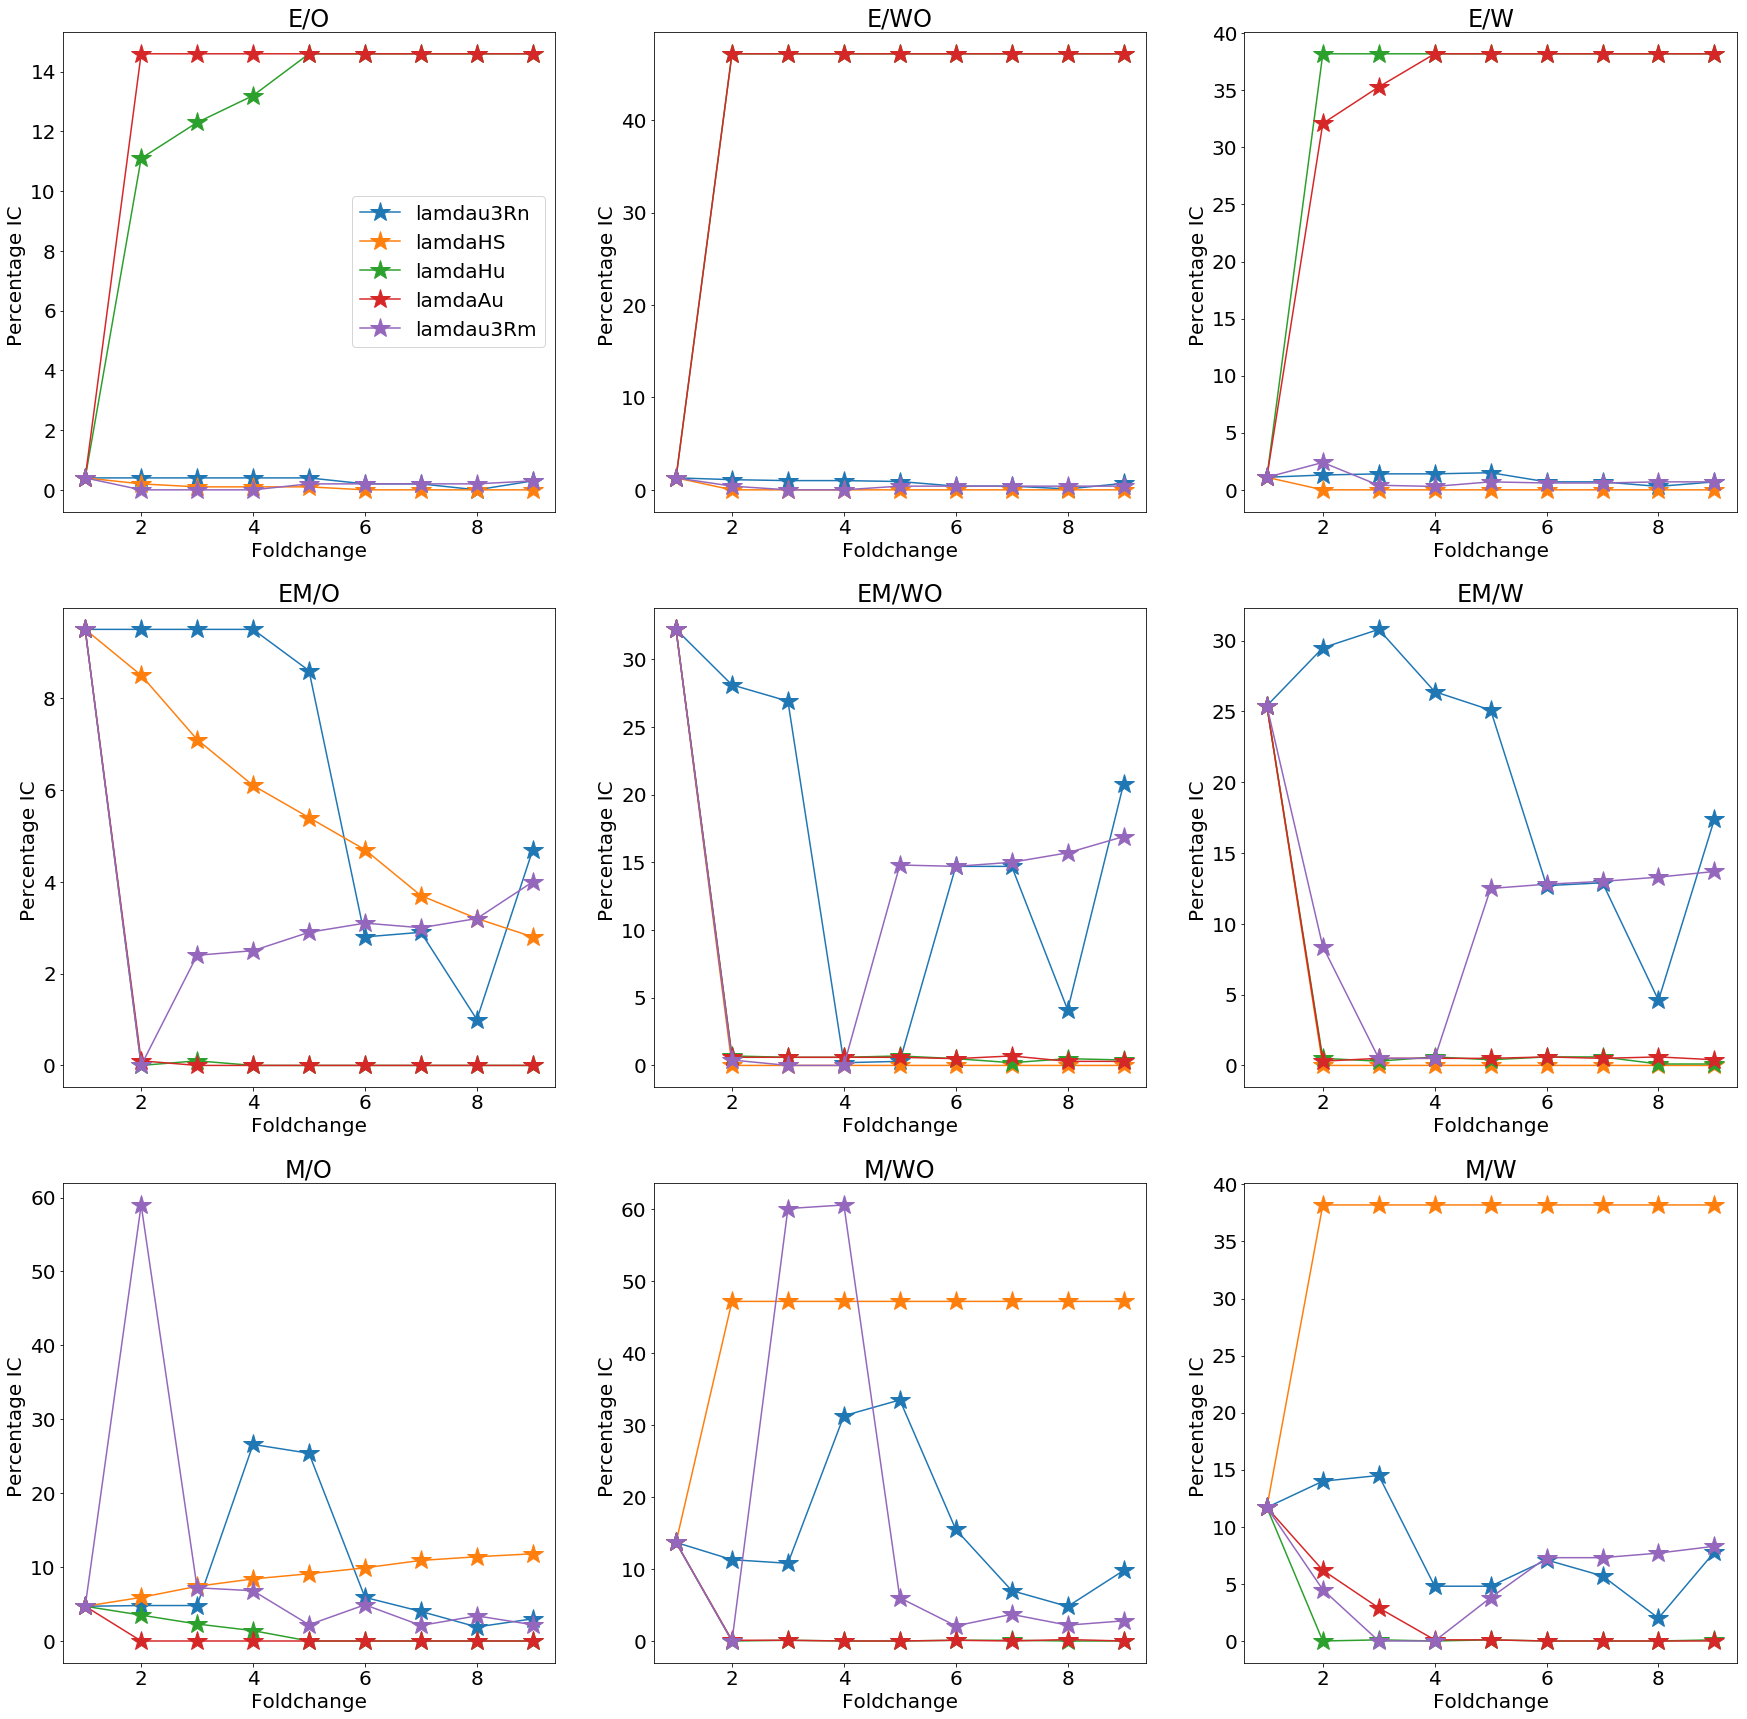

In [41]:
plotPercAll(regsA)

[0.7 0.1 0.3 0.4 0.8 0.6 0.5 0.2 0.  0.9]
lamdaAS
[0.7000000000000001, 0.1, 0.30000000000000004, 0.4, 0.8, 0.6000000000000001, 0.5, 0.2, 0.0, 0.9]
[0.  0.5 0.2 0.6 0.1 0.4 0.3 0.7 0.8 0.9]
lamdaAZ
error in  6.0
error in  6.0
[0.0, 0.5, 0.2, 0.6000000000000001, 0.1, 0.4, 0.30000000000000004, 0.7000000000000001, 0.8, 0.9]
['lamdaAS', 'lamdaAZ']
lamdaAS
101.3 

101.29999999999998 

101.19999999999999 

101.2 

101.2 

101.2 

118.4 

100.6 

100.6 

100.6 

lamdaAZ
101.2 

101.19999999999999 

101.20000000000002 

101.2 

120.60000000000001 

120.2 

119.6 

118.9 

100.6 

100.60000000000001 



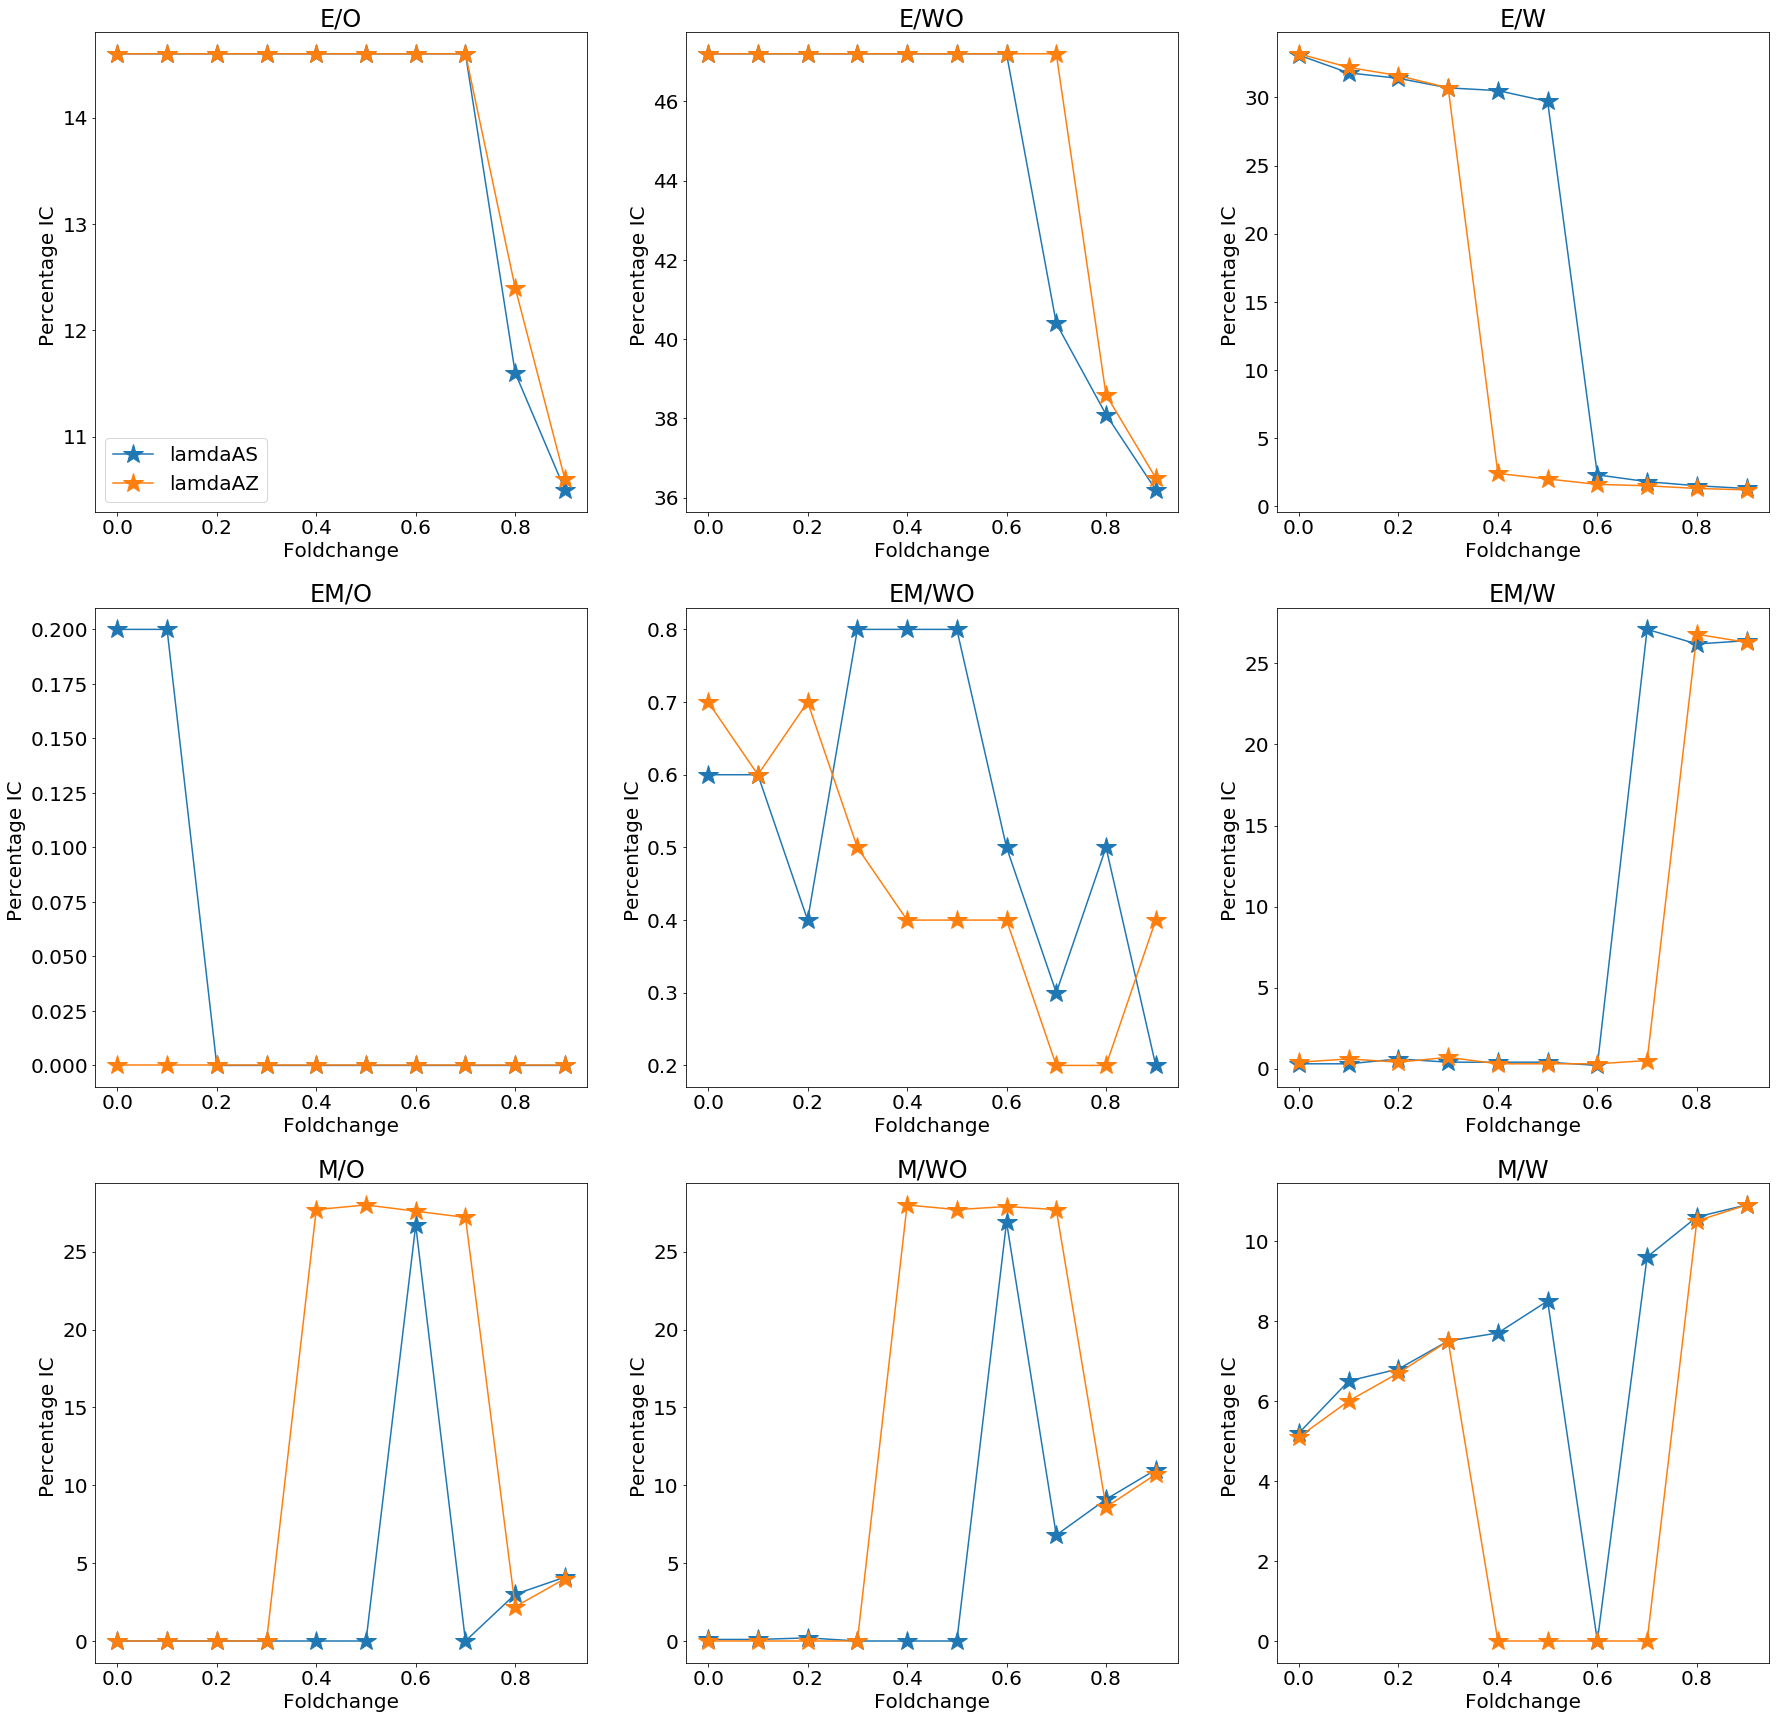

In [42]:
plotPercAll(regsI)